# DATA SCIENCE LAB IN SMART CITIES

RESEARCH QUESTION: To what extent does the presence of social and community-oriented facilities in the urban environment reduce the likelihood of a school being involved in a school shooting? Analysis on Chicago from 1990 to 2024

Francesca Del Giudice - 912367- f.delgiudice3@campus.unimib.it

Chiara Mariani - 918354 - c.mariani63@campus.unimib.it  

We first start by importing useful libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import sklearn.linear_model as linmod
import statsmodels.api as sm
import folium
import math

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from folium import Map, CircleMarker
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point, LineString


## School Shooting Data

We import the xlsx file with all the sheets.

In [2]:
excel_path = "Public v3.1 K-12 School Shooting Database (3 31 2025).xlsx"
xls = pd.ExcelFile(excel_path)
print(xls.sheet_names)

['Cover', 'Incident', 'Shooter', 'Victim', 'Weapon']


Let's start checking what we are dealing with in the *Incident* sheet.

In [3]:
df_incident = pd.read_excel(xls, sheet_name='Incident')
df_incident.head()

,Incident_ID,Month,Day,Year,Date,School,Victims_Killed,Victims_Wounded,Number_Victims,Shooter_Killed,...,Barricade,Officer_Involved,Bullied,Domestic_Violence,Gang_Related,Active_Shooter_FBI,Shots_Fired,LAT,LNG,Involves_Students_Staff
0,20250328TXPEF,3,28,2025,2025-03-28,Pete and Gracie Hosp Elementary School,0,0,0,0,...,No,No,No,No,No,No,1,33.120506,-96.883815,Yes
1,20250327MIKAK,3,27,2025,2025-03-27,Kalamazoo Public Schools administration building,0,1,1,1,...,No,No,No,No,No,No,99,42.274602,-85.600312,Yes
2,20250327NYPSB,3,27,2025,2025-03-27,P.S. 316 Elijah G. Stroud Elementary,0,0,0,0,...,No,No,No,No,NaN,No,4,40.674901,-73.960879,Yes
3,20250324TNKIM,3,24,2025,2025-03-24,KIPP Memphis Academy High School,0,1,1,0,...,No,No,No,No,No,No,NaN,35.167268,-89.987254,No
4,20250321OHFRC,3,21,2025,2025-03-21,Franklinton Prep High School,0,0,0,0,...,No,No,No,No,NaN,No,99,39.959007,-83.034307,Yes


To ensure the temporal relevance of analysis we choose to consider only data from 1990 onwards. Episodes from more than 30 years ago may not reflect the current urban, social and educational context.

In [4]:
df_incident = df_incident[df_incident['Year'] > 1989]

To plot the 10 cities with the higher number of incidents from 1990.

<ipython-input-5-587e94ce3d4b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.index, y=top_cities.values, palette='viridis')


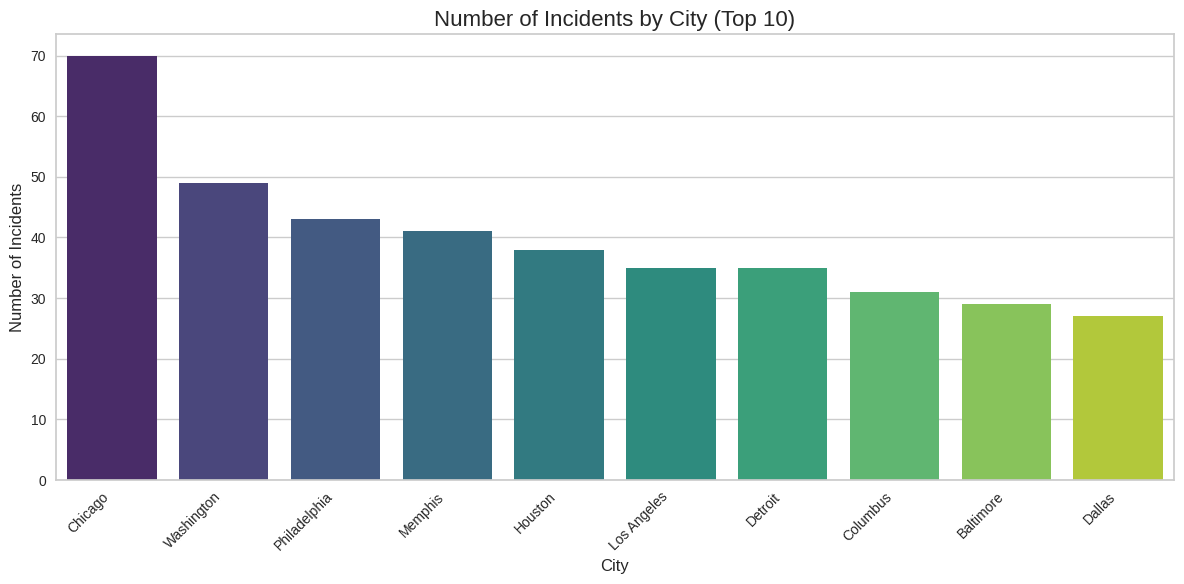

In [5]:
top_cities = df_incident['City'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.index, y=top_cities.values, palette='viridis')
plt.title('Number of Incidents by City (Top 10)', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We subsequently decide to focus only on the city of Chicago, where the largest number of incidents occurred (70). This makes the analysis more statistically robust and allows significant patterns to be identified.

In [6]:
incidents_per_city = df_incident.groupby('City').size()
incidents_per_city.idxmax(), incidents_per_city.max()

('Chicago', 70)

In [7]:
incident_chicago = df_incident[df_incident['City'] == 'Chicago']

In order to be able to perform spatial analyses, such as calculating distances or visualization on a map, it is necessary to convert the 'LAT' and 'LNG' columns into a geometry column. This transformation enables us to create a GeoDataFrame.

In [8]:
incident_chicago['geometry'] = gpd.points_from_xy(incident_chicago['LNG'], incident_chicago['LAT'])
incident_chicago = gpd.GeoDataFrame(incident_chicago, geometry='geometry', crs='EPSG:4326')

<ipython-input-8-db54a86b2ea9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incident_chicago['geometry'] = gpd.points_from_xy(incident_chicago['LNG'], incident_chicago['LAT'])


To increase the accuracy of distance and area measurements within the city of Chicago, we decide to use the coordinate system EPSG:32616.

In [9]:
incident_chicago=incident_chicago.to_crs(epsg=32616)

At the end, we associate to each school in the dataset the corresponding number of incidents. We end up a total of 65 schools and 70 incidents.

In [10]:
incident_chicago['School'] = incident_chicago['School'].str.lower()
school_chicago_incidents = incident_chicago['School'].unique()
incidents_per_school = incident_chicago['School'].value_counts().to_dict()

In [11]:
len(incidents_per_school), sum(incidents_per_school.values())

(65, 70)

To avoid any possible mistake, we remove whitespaces at the beginning and at the end of each school name and we map into the same name 'volta elementary school' and 'alessandro volta elementary school'.

In [12]:
incident_chicago['School'] = incident_chicago['School'].str.strip()

In [13]:
incident_chicago.loc[incident_chicago['School'] == 'volta elementary school', 'School'] = ' volta elementary school'

Since not all the columns in the dataset are useful for our analysis, we decide to consider only the school name, geometry and number of incidents.

In [14]:
df1 = incident_chicago[["School", "geometry"]]
df1["number"]=df1.groupby("School")["School"].transform("count")
df1 = df1.drop_duplicates(subset="School")
df1 = df1.reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
df1.columns = ['school name', 'geometry', 'number incidents']
df1

,school name,geometry,number incidents
0,perspectives leadership academy,POINT (447791.493 4621081.836),1
1,duke ellington elementary school,POINT (436398.938 4637356.174),2
2,laura s. ward elementary school,POINT (440371.15 4638146.346),1
3,william c. goudy technology academy,POINT (445499.221 4647339.895),1
4,emil g. hirsch metropolitan high school,POINT (449924.828 4622599.36),1
...,...,...,...
60,sullivan high school,POINT (444605.015 4650293.831),1
61,woodson high school,POINT (449446.26 4629304.776),2
62,orr high school,POINT (439709.872 4638246.519),1
63,tilden high school,POINT (446659.14 4628603.24),1


## School Locations Data

After collecting the schools where at least one incident happened, we import the geojson file containing all the schools in Chicago (276).

In [16]:
df_schools = gpd.read_file("school_chicago.geojson")

In [17]:
df_schools['name'] = df_schools['name'].str.lower()
school_chicago_osm = df_schools['name'].unique()
len(school_chicago_osm)

276

To improve the internal consistency of the dataset, we remove schools with the same name but different geometries, keeping only one spatial reference per school.

In [18]:
counts = df_schools['name'].value_counts()
df_schools = df_schools[df_schools['name'].isin(counts[counts == 1].index)]

As done before, we convert the geometry to EPSG:32616

In [19]:
df_schools = df_schools.to_crs(epsg=32616)

Since not all the columns in the dataset are useful for our analysis, we decide to consider only the school name, geometry and set the number of incidents equal to zero.

In [20]:
df2 = df_schools[['name', 'geometry']]
df2['incident'] = 0
df2.columns = ['school name', 'geometry', 'number incidents']
df2

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,school name,geometry,number incidents
0,all saints school,POINT (448212.798 4616412.118),0
1,annunciation school,POINT (444338.726 4640190.127),0
3,bethany school,POINT (434952.189 4640208.935),0
4,saint agnes of bohemia school,POINT (440685.838 4632601.418),0
5,christ school,POINT (436985.337 4639757.9),0
...,...,...,...
277,prairieland montessori,POINT (444044.388 4644228.589),0
278,northwestern university feinberg school of med...,POINT (448798.663 4638425.981),0
279,bronzeville scholastic institute,POINT (448040.628 4628348.049),0
280,daniel hale williams preparatory school of med...,POINT (448106.035 4628211.271),0


To avoid any possible mistake, we remove whitespaces at the beginning and at the end of each school name.

In [21]:
df2['school name'] = df2['school name'].str.strip()

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


To avoid the same school being considered as two separate entities during the analysis, we intervene manually to unify school names that are given in a different form but are semantically equivalent in df1 and df2.

In [22]:
df1.loc[df1['school name'] == 'christ of king jesuit college prep (bus)', 'school name'] = 'christ the king jesuit college prep'
df1.loc[df1['school name'] == 'st. margaret of scotland school', 'school name'] = 'saint margaret school'
df1.loc[df1['school name'] == 'collins high school', 'school name'] = 'collins south school'
df2.loc[df2['school name'] == 'perscpectives leadership academy', 'school name'] = 'perspectives leadership academy'

At this point we are ready to merge the two datasets df1 and df2. Doing so, we obtain the clean dataset with all the schools in Chicago, the corresponding geometry and the number of incidents occurred.

In [23]:
df2_unique = df2[~df2['school name'].isin(df1['school name'])]
clean_data = pd.concat([df1, df2_unique], ignore_index=True)

For our analysis, we decide also to add the column 'presence incident', which we consider as our dependent variable.

In [24]:
clean_data['presence incident'] = (clean_data['number incidents'] > 0).astype(int)
clean_data

,school name,geometry,number incidents,presence incident
0,perspectives leadership academy,POINT (447791.493 4621081.836),1,1
1,duke ellington elementary school,POINT (436398.938 4637356.174),2,1
2,laura s. ward elementary school,POINT (440371.15 4638146.346),1,1
3,william c. goudy technology academy,POINT (445499.221 4647339.895),1,1
4,emil g. hirsch metropolitan high school,POINT (449924.828 4622599.36),1,1
...,...,...,...,...
325,prairieland montessori,POINT (444044.388 4644228.589),0,0
326,northwestern university feinberg school of med...,POINT (448798.663 4638425.981),0,0
327,bronzeville scholastic institute,POINT (448040.628 4628348.049),0,0
328,daniel hale williams preparatory school of med...,POINT (448106.035 4628211.271),0,0


In [25]:
clean_data.sort_values(by='number incidents', ascending=False).head(6)

,school name,geometry,number incidents,presence incident
47,roosevelt high school,POINT (441035.43 4646322.838),3,1
1,duke ellington elementary school,POINT (436398.938 4637356.174),2,1
61,woodson high school,POINT (449446.26 4629304.776),2,1
17,catalyst circle rock charter school,POINT (436461.933 4637004.958),2,1
57,fermi elementary school,POINT (450923.3 4624106.557),1,1
56,bowen high school,POINT (453621.206 4620475.875),1,1


## Social Locations Data

Once we have all the clean data referred to schools, we start importing the geojson file with all social places in Chicago.

In [26]:
df_places = gpd.read_file("social_places_chicago.geojson")

Since we are not interesed in the name of social places, we only create a dataframe with the geometry and the type of place, which is one we selected from the list: 'theatre', 'cinema', 'cafe', 'park', 'arts_centre', 'library', 'sports_centre', 'playground'.

In [27]:
social_places = df_places[['geometry']].copy()
social_places['type'] = df_places['amenity'].fillna(df_places['leisure'])
social_places

,geometry,type
0,POINT (-87.62551 41.88481),theatre
1,POINT (-87.66933 41.97579),theatre
2,POINT (-87.60924 41.8919),cinema
3,POINT (-87.63321 41.92084),cafe
4,POINT (-87.67616 41.96164),cafe
...,...,...
839,POINT (-87.65405 41.9216),cafe
840,POINT (-87.76183 41.95308),cafe
841,POINT (-87.68725 41.9669),cafe
842,POINT (-87.67449 41.89627),cafe


To maintain coherence with what we have done before, we convert the geometry to EPSG:32616

In [28]:
social_places = social_places.to_crs(epsg=32616)

We also create 8 different dataframe, one for each social place.

In [29]:
df_theatre = social_places[social_places['type'] == 'theatre']
df_cinema = social_places[social_places['type'] == 'cinema']
df_cafe = social_places[social_places['type'] == 'cafe']
df_park = social_places[social_places['type'] == 'park']
df_library = social_places[social_places['type'] == 'library']
df_arts = social_places[social_places['type'] == 'arts_centre']
df_sports = social_places[social_places['type'] == 'sports_centre']
df_playground = social_places[social_places['type'] == 'playground']

At this point we are ready to add the 'area 1km' column to our clean_data which define a neighbourhood of 1km for each school.

In [30]:
radius = 1000
clean_data['area 1km'] = clean_data.geometry.buffer(radius)

After this, we define the function 'add_presence_social_place' which enable us to add a binary column for each social place that contains 1 if the social place is within the neighbourhood or 0 otherwise. We apply this function for each social place we consider.

In [31]:
def add_presence_social_place(df_schools, df_place, column_name):
    place_presence = df_schools['area 1km'].apply(lambda area: df_place[df_place.geometry.within(area)].shape[0] > 0)
    df_schools[column_name] = place_presence.astype(int)

In [32]:
add_presence_social_place(clean_data, df_theatre, 'presence theatre')
add_presence_social_place(clean_data, df_cinema, 'presence cinema')
add_presence_social_place(clean_data, df_cafe, 'presence cafe')
add_presence_social_place(clean_data, df_park, 'presence park')
add_presence_social_place(clean_data, df_library, 'presence library')
add_presence_social_place(clean_data, df_arts, 'presence arts')
add_presence_social_place(clean_data, df_sports, 'presence sports')
add_presence_social_place(clean_data, df_playground, 'presence playground')

At the end of all these preprocessing steps, we obtain the clean dataframe for our analysis.

In [33]:
clean_data

,school name,geometry,number incidents,presence incident,area 1km,presence theatre,presence cinema,presence cafe,presence park,presence library,presence arts,presence sports,presence playground
0,perspectives leadership academy,POINT (447791.493 4621081.836),1,1,"POLYGON ((448791.493 4621081.836, 448786.678 4...",0,0,0,0,0,0,0,0
1,duke ellington elementary school,POINT (436398.938 4637356.174),2,1,"POLYGON ((437398.938 4637356.174, 437394.122 4...",0,0,0,0,0,0,0,0
2,laura s. ward elementary school,POINT (440371.15 4638146.346),1,1,"POLYGON ((441371.15 4638146.346, 441366.334 46...",0,0,1,0,0,0,0,0
3,william c. goudy technology academy,POINT (445499.221 4647339.895),1,1,"POLYGON ((446499.221 4647339.895, 446494.406 4...",1,1,1,0,0,0,1,1
4,emil g. hirsch metropolitan high school,POINT (449924.828 4622599.36),1,1,"POLYGON ((450924.828 4622599.36, 450920.012 46...",0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,prairieland montessori,POINT (444044.388 4644228.589),0,0,"POLYGON ((445044.388 4644228.589, 445039.573 4...",1,0,1,0,0,0,0,0
326,northwestern university feinberg school of med...,POINT (448798.663 4638425.981),0,0,"POLYGON ((449798.663 4638425.981, 449793.848 4...",1,1,1,0,1,0,1,0
327,bronzeville scholastic institute,POINT (448040.628 4628348.049),0,0,"POLYGON ((449040.628 4628348.049, 449035.813 4...",0,0,1,0,0,0,0,0
328,daniel hale williams preparatory school of med...,POINT (448106.035 4628211.271),0,0,"POLYGON ((449106.035 4628211.271, 449101.22 46...",0,0,1,0,0,0,0,0


## Clustering Analysis

First of all, we have 330 schools where only 65 school are characterized by at least an incident. So, the balance of our dataset is 19.7% for class 1 and 80.3% for class 0.

In [34]:
class_1 = len(clean_data[clean_data['presence incident']==1])/len(clean_data)
class_1

0.19696969696969696

As first analysis, we can take a look at raw correlation matrix to see which variables are actually correlated both with the target variable and within themselves.

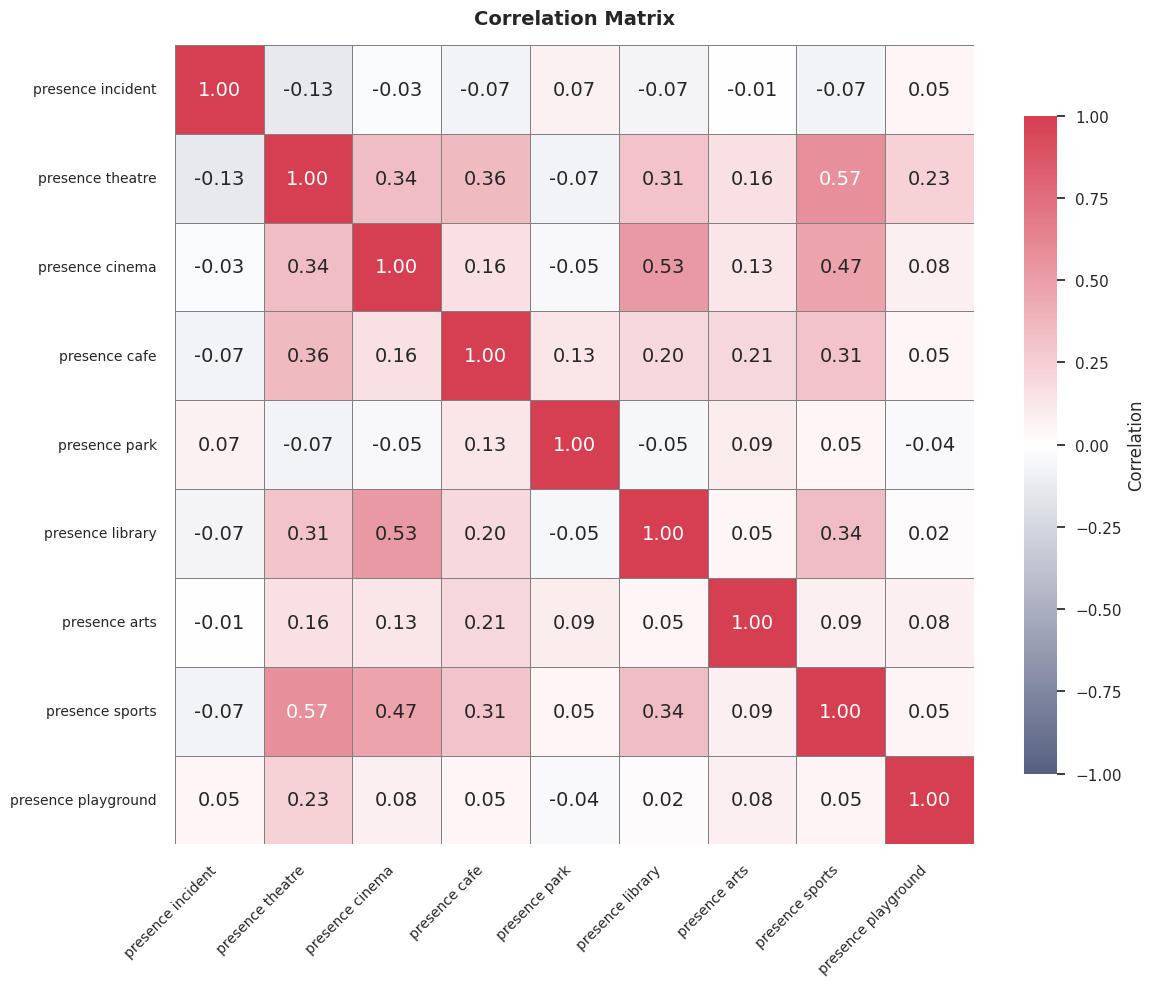

In [35]:
variables = clean_data.iloc[:, [3] + list(range(5, clean_data.shape[1]))]
corr = variables.corr()

sns.set_theme(style="whitegrid")

colors = ["#576082", "white", "#d63e51"]
cmap = LinearSegmentedColormap.from_list("dark_bwr", colors, N=256)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap=cmap,
    vmin=-1, vmax=1,
    annot=True,
    annot_kws={"size": 14},
    fmt=".2f",
    linewidths=0.6,
    linecolor='gray',
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Correlation Matrix', fontsize=14, weight='bold', pad=15)
plt.tight_layout()
plt.show()


We define the set of independent variables, which corresponds to binary columns related to the presence of social places in the neighbourhood of each school.

In [36]:
x = clean_data.iloc[:, 5:].values

The first thing we need to assess to proceed and perform clustering is the number of clusters. To do this we decide to use the Silhoutte score and the Distortion score, that both identify the best number of clusters as k=4.

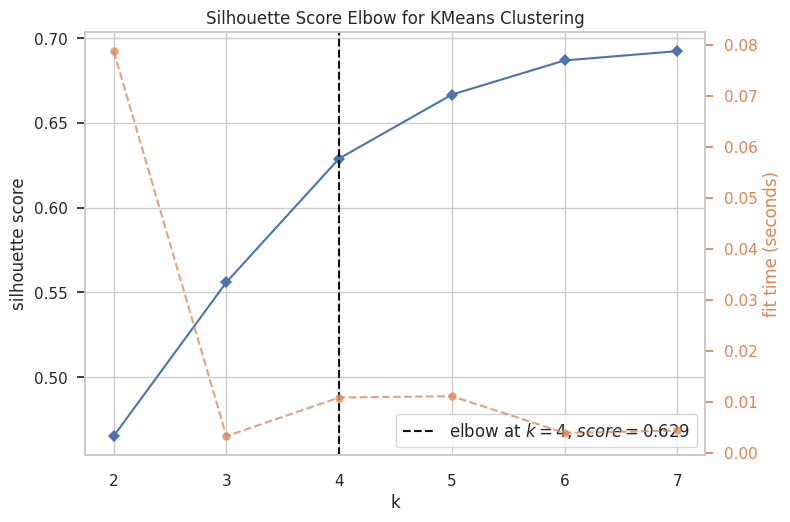

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [37]:
visualizer=KElbowVisualizer(KMeans(random_state=4), k=(2,8), metric='silhouette')
visualizer.fit(x)
visualizer.show()

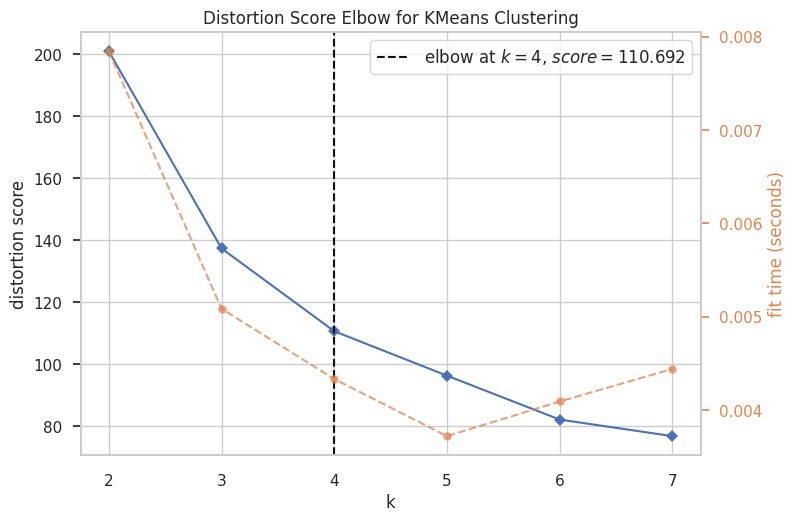

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
visualizer=KElbowVisualizer(KMeans(random_state=4), k=(2,8), metric='distortion')
visualizer.fit(x)
visualizer.show()

To assess different assumptions on the shape, density and distribution of the data, we try out three different clustering algorithms (KMeans, Agglomerative and Spectral). Assessing the stability and consistency of the generated clusters, through internal metrics such as the silhoutte score, we select the KMeans as the best one.

In [39]:
n_clusters=4

models = {
    "KMeans": KMeans(n_clusters=n_clusters, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=n_clusters),
    "SpectralClustering": SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42),
}

for name, model in models.items():
    clusters = model.fit_predict(x)
    score = silhouette_score(x, clusters)
    print(f"{name}: Silhouette Score = {score:.3f}")


KMeans: Silhouette Score = 0.645
Agglomerative: Silhouette Score = 0.606
SpectralClustering: Silhouette Score = 0.638


We add the corresponding cluster for each school in the column 'cluster' and we compute the percentage of incident for each cluster.

In [40]:
clean_data["cluster"]=clusters
clean_data.groupby('cluster')['presence incident'].mean()

,presence incident
cluster,
0,0.075758
1,0.236220
2,0.201835
3,0.285714


After having seen the similar means of cluster 1,2,3, we put them together.

In [41]:
clean_data.loc[clean_data["cluster"]==2, "cluster"]=1
clean_data.loc[clean_data["cluster"]==3, "cluster"]=1

We now use the t-SNE algorithm to reduce the dimensionality of the data and visualise the distribution of the clusters obtained with KMeans in a two-dimensional space.

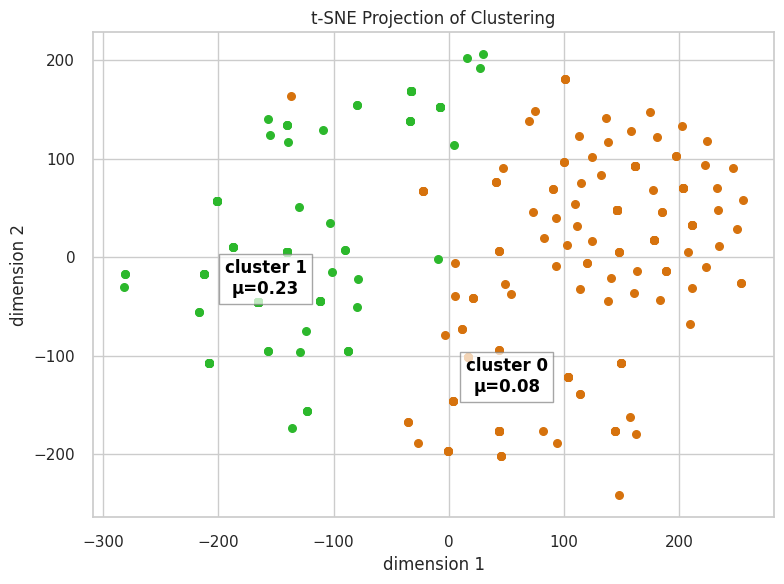

In [42]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(x)

mean_incidents = clean_data.groupby('cluster')['presence incident'].mean()

colors = ["#d6720d","#2cb82c" ]
plt.figure(figsize=(8, 6))

for i, cluster_id in enumerate(np.unique(clusters)):
    idx = (clusters == cluster_id)
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1],
                color=colors[i % len(colors)],
                s=30, label=f'Cluster {cluster_id}', alpha=1)

n_clusters = len(np.unique(clusters))
for i in range(2):
    idx = (clusters == i)
    x_mean = np.mean(X_tsne[idx, 0])
    y_mean = np.mean(X_tsne[idx, 1])
    label = f"cluster {i}\nμ={mean_incidents[i]:.2f}"
    plt.text(x_mean, y_mean, label, fontsize=12, weight='bold',
             color='black', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.title('t-SNE Projection of Clustering')
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
plt.tight_layout()
plt.show()

Considering also the independent variables, we compute the mean of each column to analyze the impact of each feature in each cluster.

In [43]:
columns = ['presence theatre', 'presence cinema', 'presence cafe',
           'presence park', 'presence library', 'presence arts',
           'presence sports', 'presence playground']

mean_per_cluster = clean_data.groupby('cluster')[columns].mean()
mean_per_cluster

,presence theatre,presence cinema,presence cafe,presence park,presence library,presence arts,presence sports,presence playground
cluster,,,,,,,,
0,0.909091,0.333333,0.984848,0.000000,0.333333,0.257576,0.575758,0.151515
1,0.000000,0.011364,0.518939,0.030303,0.022727,0.132576,0.034091,0.030303


From the difference between the percentage values of each variable in the two clusters, we select the most meaningful ones (difference > 0.3): theatre, cinema, cafe, library, sports. With these we perform logistic regression to confirm the impact on the incident probability.

## Logistic Regression Analysis

We start by computing the VIF of all variables selected after the clustering, that quantifies multicollinearity, so how much one feature is linearly related to the others in a regression model.

In [44]:
x = clean_data[['presence theatre', 'presence cinema','presence cafe',
                'presence library', 'presence sports']]
x_with_const = sm.add_constant(x)

vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x_with_const.values, i+1) for i in range(len(x.columns))]

print(vif_data)


            feature       VIF
0  presence theatre  1.602052
1   presence cinema  1.609342
2     presence cafe  1.176917
3  presence library  1.439623
4   presence sports  1.740472


We see that for all the independent variable considered we have a VIF < 10. This low value confirms that there is no collinearity between variables, so we can include all the variables in the regression.

We define the dependent variable y which is the presence of incidents and, since the dataset presents an imbalance between classes, the Stratified K-Fold Cross-Validation method is used. This guarantees that the proportion of classes is kept constant in each fold, ensuring a more realistic and stable evaluation of the model's performance. We also train the Logistic Regression with the parameter class weight balanced, which automatically adjusts the weight of classes inversely to their frequency. This avoids bias towards the majority class and improves the model's ability to recognise the minority class. Moreover, due to class imbalance, the accuracy is not enough and for this reason we also compute the precision, recall, F1-score and AUC.

In [45]:
y = clean_data['presence incident']

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

acc_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
auc_scores = []
mcc_scores = []
weights = []
intercepts = []

for train_index, test_index in kf.split(x, y):
    X_train = x.iloc[train_index]
    X_test = x.iloc[test_index]
    Y_train = y.iloc[train_index]
    Y_test = y.iloc[test_index]

    model = linmod.LogisticRegression(max_iter=1000, penalty=None, class_weight="balanced")
    model.fit(X_train, Y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    acc_scores.append(accuracy_score(Y_test, y_pred))
    f1_scores.append(f1_score(Y_test, y_pred, average='binary'))
    precision_scores.append(precision_score(Y_test, y_pred, average='binary'))
    recall_scores.append(recall_score(Y_test, y_pred, average='binary'))
    auc_scores.append(roc_auc_score(Y_test, y_prob[:, 1]))

    weights.append(model.coef_.flatten())
    intercepts.append(model.intercept_)

metrics_summary = {
    'accuracy': np.mean(acc_scores),
    'f1_score': np.mean(f1_scores),
    'precision': np.mean(precision_scores),
    'recall': np.mean(recall_scores),
    'auc': np.mean(auc_scores)
}

model_parameters_summary = {
    'intercept': np.mean(intercepts, axis=0),
    'weights': np.mean(weights, axis=0)
}

What is of particular interest for our analysis are the value of the intercept and coefficients to assess the impact of each feature.

In [46]:
metrics_summary, model_parameters_summary

({'accuracy': np.float64(0.3666666666666667),
  'f1_score': np.float64(0.3190604445337646),
  'precision': np.float64(0.20221923653557838),
  'recall': np.float64(0.7904761904761904),
  'auc': np.float64(0.5046805046805047)},
 {'intercept': array([0.22017469]),
  'weights': array([-1.19801318,  0.79621207, -0.12884752, -0.64709616, -0.02698166])})

## Visualizations

Example of a 1-kilometer buffer zone around Sullivan High School in Chicago where each icon represents a category of social infrastructure included in the dataset.

In [47]:
data = clean_data.to_crs(epsg=32616)
places = social_places.to_crs(epsg=32616)


index = 60
selected_school = data.iloc[index]
buffer_1km = selected_school.geometry.buffer(1000)


center_point = selected_school.geometry
distance = 1000
angle_deg = 135
angle_rad = math.radians(angle_deg)
dx = distance * math.cos(angle_rad)
dy = distance * math.sin(angle_rad)
point_on_left = Point(center_point.x + dx, center_point.y + dy)
line = LineString([center_point, point_on_left])
line_gdf = gpd.GeoDataFrame(geometry=[line], crs='EPSG:32616').to_crs(epsg=4326)

places_within_buffer = places[places.geometry.within(buffer_1km)]

data = data.to_crs(epsg=4326)
places = places.to_crs(epsg=4326)
places_within_buffer = places_within_buffer.to_crs(epsg=4326)
selected_school = data.iloc[index]

m = folium.Map(location=[selected_school.geometry.y, selected_school.geometry.x], zoom_start=14)

folium.Marker(
    location=[selected_school.geometry.y, selected_school.geometry.x],
    popup=f"School: {selected_school['school name']}",
    icon=folium.Icon(color='lightred', icon='star')
).add_to(m)
icons_colours = {
    'theatre': ('ticket', 'cadetblue'),
    'cinema': ('film', 'cadetblue'),
    'cafe': ('coffee', 'cadetblue'),
    'park': ('tree', 'cadetblue'),
    'library': ('book', 'cadetblue'),
    'arts_centre': ('paint-brush', 'cadetblue'),
    'sports_centre': ('futbol', 'cadetblue'),
    'playground': ('child', 'cadetblue')
}

for idx, row in places_within_buffer.iterrows():
    type = row['type']
    icon, colour = icons_colours.get(type, ('info-sign', 'gray'))
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"Type: {row['type']}",
        icon=folium.Icon(color=colour, icon=icon, prefix='fa')
    ).add_to(m)

buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_1km], crs='EPSG:32616')
buffer_gdf = buffer_gdf.to_crs(epsg=4326)

folium.GeoJson(
    buffer_gdf,
    name='Buffer 1km',
    style_function=lambda x: {
        'fillColor': 'white',
        'color': '#426877',
        'weight': 2,
        'fillOpacity': 0.5
    },
    tooltip="Real 1 km  radius area"
).add_to(m)

coords = list(line_gdf.geometry.iloc[0].coords)
folium.PolyLine(
    locations=[(y, x) for x, y in coords],
    color= '#426877',
    weight=2,
    opacity=1
).add_to(m)

mid_x = (coords[0][0] + coords[1][0]) / 2
mid_y = (coords[0][1] + coords[1][1]) / 2
folium.Marker(
    location=[mid_y, mid_x],
    icon=folium.DivIcon(
        icon_size=(150, 36),
        icon_anchor=(0, 0),
        html='<div style="font-size: 18px; color: #426877;"><b>1 km</b></div>'
    )
).add_to(m)

m